<a href="https://colab.research.google.com/github/danielAmar02/Challenge_ENS/blob/main/Proligens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive,files


drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/earthcube-lab/challenge-ens.git

Cloning into 'challenge-ens'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 201 (delta 127), reused 187 (delta 115), pack-reused 0
Receiving objects: 100% (201/201), 43.97 KiB | 569.00 KiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
!pip3 install framework

ERROR: Could not find a version that satisfies the requirement framework
ERROR: No matching distribution found for framework


In [ ]:
from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
from tqdm import tqdm
%cd /content/challenge-ens/framework/
from dataset import LandCoverData as LCD

/content/challenge-ens/framework


In [ ]:
DATA_FOLDER_STR = "/content/gdrive/MyDrive/Preligens"
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
# path to the unzipped dataset: contains directories train/ and test/
DATASET_FOLDER = DATA_FOLDER/""
# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('Train/images/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('Train/images/masks/masks/*.tif')))
# get all test images
test_images_paths = sorted(list(DATASET_FOLDER.glob('Test/test/images/*.tif')))

OSError: ignored

In [ ]:
train_masks_paths

[PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/1.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/100.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/1000.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10000.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10001.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10002.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10003.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10004.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10005.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10006.tif'),
 PosixPath('/content/gdrive/MyDrive/Preligens/Train/images/masks/masks/10007.tif'),
 P

In [ ]:
len(train_images_paths)

18491

# Some Statistic

In [ ]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(image)
    return im


def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        # show legend mapping pixel colors to class names
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

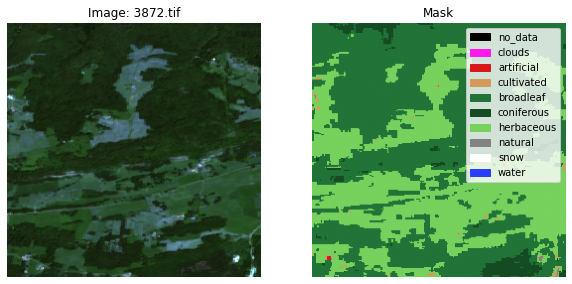

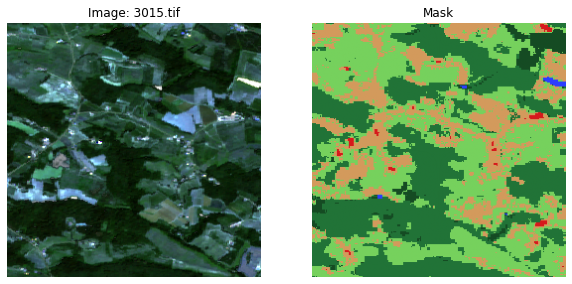

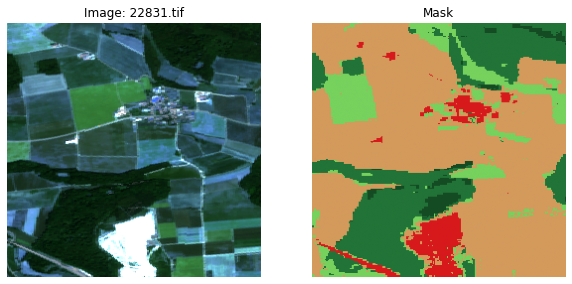

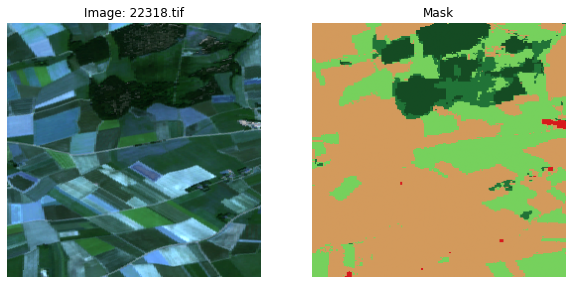

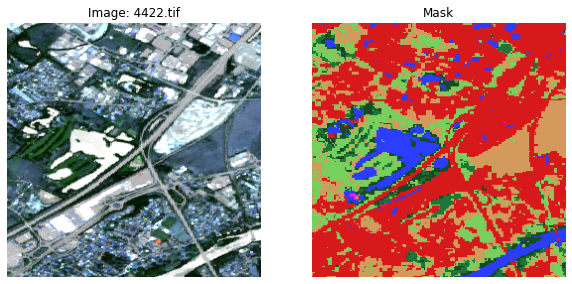

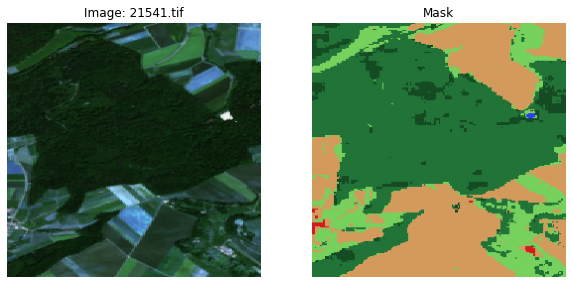

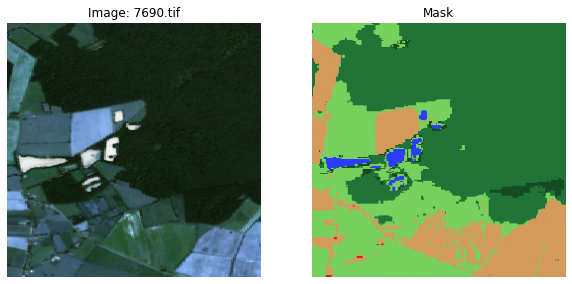

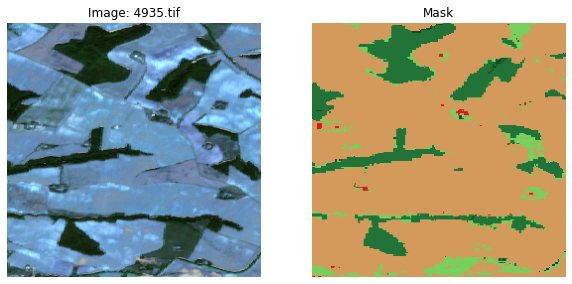

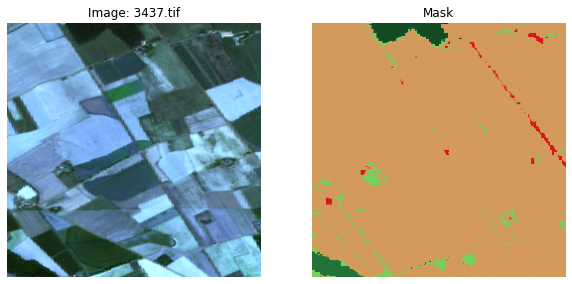

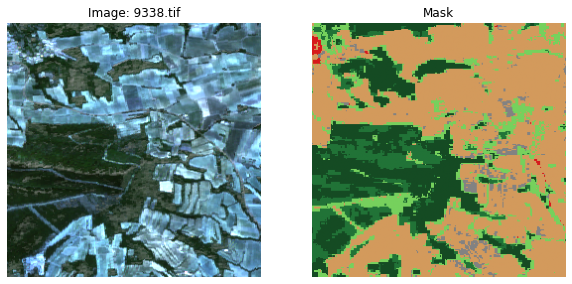

In [ ]:
# Show 10 random (image, mask) pairs from the training set
for k, idx in enumerate(random.sample(range(len(train_images_paths)), 10)):
    image_path = train_images_paths[idx]
    mask_path = train_masks_paths[idx]
    assert image_path.name == mask_path.name
    
    with TiffFile(image_path) as tif:
        arr = tif.asarray()        
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    show_image(arr, display_min=0, display_max=2200, ax=axs[0])
    
    with TiffFile(mask_path) as tif:
        arr = tif.asarray()
    classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
    show_mask(arr,
              classes_colorpalette = classes_colorpalette,
              classes=LCD.CLASSES,
              add_legend=(k == 0),
              ax=axs[1]
    )
    axs[0].set_title(f'Image: {image_path.name}')
    axs[1].set_title('Mask')
    #fig.tight_layout()

In [ ]:
def plot_class_distributions(class_counts, classes=None, class_colors=None):
    """Plot the proportion of the number of pixels for every class
    Args:
        class_counts (numpy.array): the raw class counts of shape (N_CLASSES,)
        classes (list[str], optional): list of class labels
        class_colors (numpy.array, optional): array of colors of shape (N_CLASSES, 3) in [0, 1]
    """
    rc_dict = { # font params for display
        'axes.titlesize': 19,
        'axes.labelsize': 16,
        'lines.linewidth': 2,
        'lines.markersize': 8,
        'font.size': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    }
    with plt.style.context(['seaborn', rc_dict]):
        class_dist = class_counts / class_counts.sum()
        fig, ax = plt.subplots(figsize=(12, 8))
        rects = ax.bar(range(len(class_dist)), class_dist, color=class_colors)
        ax.set_xticks(range(len(class_dist)))
        if classes is not None:
            ax.set_xticklabels(classes, rotation=90)
       
        for i, v in enumerate(class_counts):
            ax.text(i, class_dist[i] + 0.005, "{:.2e}".format(v))
        ax.set_xlabel("Classes")
        ax.set_ylabel("Proportion of the number of pixels")
        ax.set_title("Training set")

def compute_class_counts(masks_paths, n_classes=10):
    """Return the cumulated class counts for all masks in the training set.
    Args:
        masks_paths (list[path-like]): paths to all masks 
    """
    cumcount = np.zeros((n_classes,), dtype=np.int64)
    for path in tqdm(train_masks_paths):
        with TiffFile(path) as tif:
            arr = tif.asarray()
            count = np.bincount(arr.ravel(), minlength=10)
            # hist, _ = np.histogram(arr, bins=n_classes, range=(0, 10)) # @todo: use bincount
            cumcount += count
    return cumcount
    
train_class_counts = compute_class_counts(train_masks_paths, n_classes=LCD.N_CLASSES)
# this should be equal to LandCoverData.TRAIN_CLASS_COUNTS
assert (train_class_counts == LCD.TRAIN_CLASS_COUNTS).all()
# normalize to get a distribution
train_class_dist = train_class_counts / train_class_counts.sum()


100%|██████████| 18491/18491 [2:03:57<00:00,  2.49it/s]


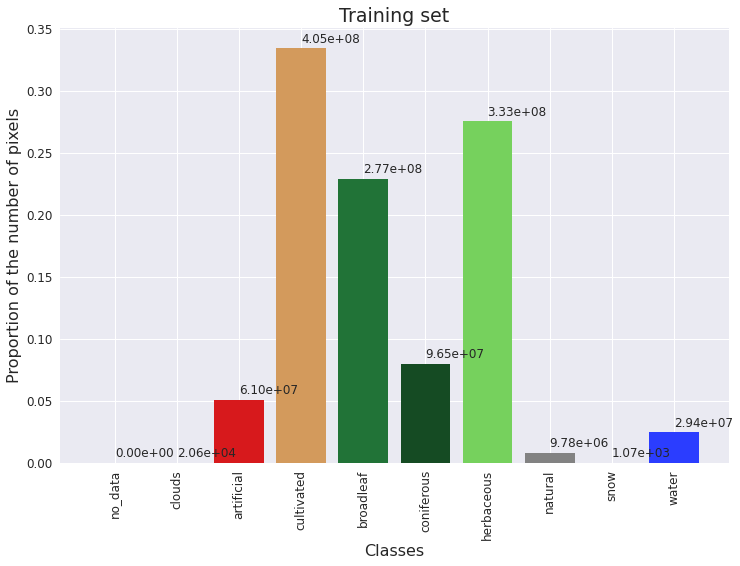

In [ ]:
plot_class_distributions(
    train_class_counts,
    classes=list(LCD.CLASSES),
    class_colors = np.asarray(list(LCD.CLASSES_COLORPALETTE.values()))/255.
)

In [ ]:
!pip install tensorflow=2.2.0
!pip install tensorflow-addons=0.11.2
!pip install ipython=5.8.0


ERROR: Invalid requirement: 'tensorflow=2.2.0'
Hint: = is not a valid operator. Did you mean == ?
ERROR: Invalid requirement: 'tensorflow-addons=0.11.2'
Hint: = is not a valid operator. Did you mean == ?
ERROR: Invalid requirement: 'ipython=5.8.0'
Hint: = is not a valid operator. Did you mean == ?


In [ ]:
import pillow
import numpy 
import matplotlib
import ipython
import pandas
import tifffile
import tqdm
import tensorflow 
import tensorflow-addons

In [ ]:
!ipython /content/challenge-ens/framework/eval.py -- --gt-file path/to/labels.csv --pred-file path/to/predicted.csv -o /path/to/save.csv
